#   CIFAR-10 Classifier Documentation Using SVM

Author: Filip Gębala

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

## SVM Model
Support Vector Machine (SVM) is a supervised classification method that finds the optimal hyperplane separating data in feature space. The model aims to maximize the margin — the distance between the hyperplane and the nearest data points from both classes — leading to better generalization and resistance to noise.

When applied to CIFAR-10 image data, RGB images are first transformed into tensors and then flattened into feature vectors. Due to the high dimensionality of the data (3072 features per image), before classification, standardization and dimensionality reduction using Principal Component Analysis (PCA) are applied. PCA reduces the data to 300 dimensions, which not only speeds up training but also helps remove noise and correlations between features.

The SVM classifier uses the Radial Basis Function (RBF) kernel, which allows it to model non-linear decision boundaries. The model is trained with the regularization parameter C=10 and an automatically tuned gamma set to "scale", ensuring a good fit with moderate overfitting risk. Training is done on a subset of 100,000 training samples, and testing is performed on 1,000 samples from the CIFAR-10 test set.

Thanks to dimensionality reduction and standardization, the classifier achieves decent accuracy considering the limitations of not using specialized feature extraction (like in CNNs). The SVM model works well as a baseline classifier or a component of larger classification systems, especially when combined with dimensionality reduction and preprocessing techniques.

## Data Preparation
Similar to CNNs, data is loaded using torchvision. However, no augmentation or normalization is applied because the data will later be transformed using StandardScaler. Additionally, since the full CIFAR-10 dataset contains 50,000 samples, we use a subset of the data (e.g., 10,000) to shorten the training time for SVM. Each image is flattened into a vector for use as input to the SVM.

In [ ]:
# === TRANSFORMATION ===
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# === LOAD DATASET (train on a sample) ===
trainset = torchvision.datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root="../data", train=False, download=True, transform=transform)

# Sample a small subset
def get_data(dataset, n_samples):
    loader = torch.utils.data.DataLoader(dataset, batch_size=n_samples, shuffle=True)
    images, labels = next(iter(loader))
    images = images.view(images.size(0), -1)
    return images.numpy(), labels.numpy()

X_train, y_train = get_data(trainset, 100000)
X_test, y_test = get_data(testset, 1000)

100%|██████████| 170M/170M [00:51<00:00, 3.32MB/s]   


## Data Visualisation and Analysis

In [12]:
print("Number of images in the training set:", len(trainset))
print("Number of images in the test set:", len(testset))
print("Number of classes:", len(trainset.classes))
print("Class names:", trainset.classes)

# Class distribution in the training and test sets

train_labels = [label for _, label in trainset]
test_labels = [label for _, label in testset]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print("\nClass distribution in the training set:")
for idx, cls in enumerate(trainset.classes):
    print(f"{cls}: {train_counts[idx]}")

print("\nClass distribution in the test set:")
for idx, cls in enumerate(testset.classes):
    print(f"{cls}: {test_counts[idx]}")

# Example image shape:
img, _ = trainset[0]
print("\nImage shape:", img.shape)

Number of images in the training set: 50000
Number of images in the test set: 10000
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Class distribution in the training set:
airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000

Class distribution in the test set:
airplane: 1000
automobile: 1000
bird: 1000
cat: 1000
deer: 1000
dog: 1000
frog: 1000
horse: 1000
ship: 1000
truck: 1000

Image shape: torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54291844..1.4049683].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29893935..1.2754133].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41192818..1.4869226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37142462..1.8007375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3781029..1.3577807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48513132..1.7047619].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4

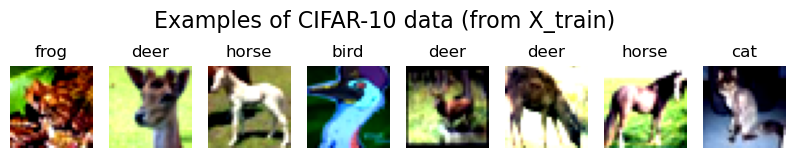

In [11]:
def imshow(img):
    img = img / 2 + 0.5  # Denormalisation
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

num_samples_to_show = 8
if 'X_train' in locals() and 'y_train' in locals() and 'trainset' in locals() and len(X_train) >= num_samples_to_show:
    sample_images_flat_np = X_train[:num_samples_to_show]  # X_train contains flattened images
    sample_labels_np = y_train[:num_samples_to_show]

    # Reshape flattened images (3072 features) back to (3, 32, 32) for display
    # X_train stores them as (n_samples, 3*32*32)
    sample_images_reshaped_np = sample_images_flat_np.reshape(-1, 3, 32, 32)

    plt.figure(figsize=(10, 2)) 
    for i in range(num_samples_to_show): 
        plt.subplot(1, num_samples_to_show, i + 1)
        img_tensor = torch.from_numpy(sample_images_reshaped_np[i])
        imshow(img_tensor)
        plt.title(trainset.classes[sample_labels_np[i]])
    plt.suptitle(f"Examples of CIFAR-10 data (from X_train)", fontsize=16)
    plt.show()
else:
    print("Could not generate plot: X_train, y_train, or trainset not found, or not enough samples.")
    print("Please ensure the cell that defines X_train, y_train (cell 5) and trainset has been run.")

## Preprocessing: Standardization and PCA
Standardizing the data is crucial when using SVM. After that, dimensionality reduction is performed using PCA, which speeds up training and improves algorithm stability. The dimensionality is reduced from 3072 to 300.

In [10]:
# === Standardize the data ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)

# === PCA (Principal Component Analysis) ===
n_components = 0.95 # Keep enough components to explain 95% of the variance
pca = PCA(n_components=n_components)  
X_train_pca = pca.fit_transform(X_train)  
X_test_pca = pca.transform(X_test)        

# === Output the results ===
print(f"Number of PCA components selected to explain {n_components * 100.0}% of the variance: {pca.n_components_}")
print(f"Total explained variance by selected components: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")


Number of PCA components selected to explain 95.0% of the variance: 221
Total explained variance by selected components: 95.02%


## Training the SVM Model
The SVM is trained using the RBF (Gaussian) kernel. The C=10 parameter sets the penalty for classification errors, and gamma='scale' automatically adjusts the RBF kernel width to the data. Training may take a few minutes depending on the number of samples and the performance of the computer.

In [ ]:
# === TRAINING ===
clf = svm.SVC(kernel='rbf', C=10, gamma='scale')
print("Training...")
clf.fit(X_train_pca, y_train)

## Testing the Model

In [ ]:
# === TESTING ===
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

## Plots

1. Explained Variance by PCA
<br>
To evaluate how much of the variance is explained by the reduced components, we can visualize the cumulative explained variance using PCA:

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance by PCA")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

2. PCA for Visualization in 2D
<br>
We can visualize the data in two dimensions to get an intuitive understanding of how well PCA has separated the data:

In [ ]:
pca_2d = PCA(n_components=2)
X_vis = pca_2d.fit_transform(X_train)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train, cmap='tab10', alpha=0.5, s=10)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("Training Data after PCA (2 Components)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()

3. Confusion Matrix 
<br>
To further analyze the performance of the model, the confusion matrix can provide detailed insights into misclassifications:

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM on CIFAR-10")
plt.tight_layout()
plt.show()

## Results and Summary
SVM can achieve good results even without deep learning, especially with proper dimensionality reduction (PCA) and well-tuned parameters. Compared to CNNs, SVM is less prone to overfitting, but its effectiveness might be limited by the lack of non-linear, multi-layered data representations.

In this case, unfortunately, SVM did not perform well — achieving an accuracy of ~55%. This is mainly due to the large image size, which distorts the hyperplane significantly.